# 1. Import Packages

In [2]:
import numpy as np 
import pandas as pd 
import nltk
import matplotlib.pyplot as plt
import random
import re
import string
import pickle
from nltk.corpus import stopwords # module for stop words
from nltk.stem import PorterStemmer # module for stemming
from nltk.tokenize import TweetTokenizer # module for tokenizing strings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [3]:
# # download the stop words
# nltk.download('stopwords')

# 2. Data Cleaning

## 2.1. Explore the dataset
Look at the number of training dataset that is with label 1 (related to disaster) versus lable 0 (not related to disaster)

In [4]:
# import train dataset
raw_df = pd.read_csv("/kaggle/input/nlpgettingstarted/train.csv")
test_df = pd.read_csv("/kaggle/input/nlpgettingstarted/test.csv")
# check the number of dataset with label 1 and 0 
print("number of disaster sample:", len(raw_df[raw_df["target"] == 1]))
print("number of not disaster sample:", len(raw_df[raw_df["target"] == 0]))

number of disaster sample: 3271
number of not disaster sample: 4342


## 2.2 Train/Validation Split
Since the test dataset is given, I am creating the train and validation sets to find the best $\theta$ that minimize the cost without overfitting
* Train: 80% of disaster sample + 80% of not disaster sample
* Validation: 20% of disaster sample + 20% of not disaster sample

In [5]:
# disaster sample
X_train_dis, X_val_dis, y_train_dis, y_val_dis = train_test_split(raw_df[raw_df["target"] == 1]['text'], 
                                                                    raw_df[raw_df["target"] == 1]['target'],
                                                                    test_size=0.20, random_state=42, shuffle=True)

# not disaster sample 
X_train_ndis, X_val_ndis, y_train_ndis, y_val_ndis = train_test_split(raw_df[raw_df["target"] == 0]['text'], 
                                                                    raw_df[raw_df["target"] == 0]['target'],
                                                                    test_size=0.20, random_state=42, shuffle=True)
X_train = pd.concat([X_train_dis, X_train_ndis], axis = 0).reset_index(drop = True).to_frame()
y_train = pd.concat([y_train_dis, y_train_ndis], axis = 0).reset_index(drop = True).to_frame()
train_df = pd.concat([X_train, y_train], axis = 1)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle dataset


X_val = pd.concat([X_val_dis, X_val_ndis], axis = 0).reset_index(drop = True).to_frame()
y_val = pd.concat([y_val_dis, y_val_ndis], axis = 0).reset_index(drop = True).to_frame()
val_df = pd.concat([X_val, y_val], axis = 1)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle dataset


In [6]:
train_df.shape

(6089, 2)

## 2.2. Data Cleaning and Tokenizing
1. Remove the hash tag
2. Remove hyperlink
3. Remove any word that start with @
4. Tokenize the text
5. Remove stop words
6. Remove punctuation
7. Stemming

In [7]:
# Initialize tokenizer, which will make the string to be list and lowercase all the words
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)

# Initialize stemmer, which will be used to stem the word
stemmer = PorterStemmer()

In [8]:
def clean_tokenize(text):
    """Process text function.
    Input:
        text: the text of the tweet
    Output:
        clean_token: a list of words containing the processed tweet

    """
    # remove hashtags
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)
    
    # remove hyperlink
    text = re.sub(r'https?://[^\s\n\r]+', '', text)

    # remove @
    text = re.sub('@.*? ', '', text)

    # remove ...
    text = re.sub('\.\.\.', '', text)

    # remove \x89
    text = re.sub(r'\x89', '', text)

    # Tokenize the text, which will also lowercase the word
    text_token = tokenizer.tokenize(text)

    # remove stop words, punctuation and stem the word
    clean_token = []
    for word in text_token:
        if (word not in stopwords.words('english') and  # remove stopwords
            word not in string.punctuation):   # remove punctuation
            # stemming
            clean_word = stemmer.stem(word)
            clean_token.append(clean_word)
    return clean_token


In [9]:
# clean training dataset

train_df['Remove_Hash_Link_At'] = train_df['text'].map(clean_tokenize)

# clean validation dataset
val_df['Remove_Hash_Link_At'] = val_df['text'].map(clean_tokenize)

# clean testing datast
test_df['Remove_Hash_Link_At'] = test_df['text'].map(clean_tokenize)

# Vanishing Gradient Return
1. Apply TfidfVectorizer

    a. TfidfVectorizer is a tool from scikit-learn that transforms a list of text documents into a matrix of TF-IDF features.

   
    b. TF-IDF = Term Frequency – Inverse Document Frequency

2. Scale the Dataset

    a. Upon the first logistic regression training, I had discovered my model face the vanishing gradient return, where the gradient vector is too small for the model to update the $\theta$ vector. To avoid this issue, I had decided to scale the data prior to training my logistic regression model.

3. Apply PCA



In [10]:
# Combine the text to fit into the TfidVectorizer
train_df["Remove_Hash_Link_At_Combine"] = train_df['Remove_Hash_Link_At'].apply(lambda tokens: ' '.join(tokens))
# val_df["Remove_Hash_Link_At_Combine"] = val_df['Remove_Hash_Link_At'].apply(lambda tokens: ' '.join(tokens))
# test_df["Remove_Hash_Link_At_Combine"] = test_df['Remove_Hash_Link_At'].apply(lambda tokens: ' '.join(tokens))

In [11]:
# Apply TfidVectorizer
vectorizer = TfidfVectorizer()
train_tfidf = vectorizer.fit_transform(train_df["Remove_Hash_Link_At_Combine"])
train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
train_tfidf.index = train_df.index  # So we can merge later

In [12]:
# Scale the Data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_tfidf)

In [13]:
# Apply the PCA
pca = PCA(n_components=0.90)
train_pca = pca.fit_transform(train_scaled)

train_pca_df = pd.DataFrame(train_pca, columns=[f"PCA_{i+1}" for i in range(train_pca.shape[1])], index=train_df.index)

In [14]:
train_df_fnl = pd.concat([train_df, train_pca_df], axis = 1)
train_df_fnl

,text,target,Remove_Hash_Link_At,Remove_Hash_Link_At_Combine,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,...,PCA_3300,PCA_3301,PCA_3302,PCA_3303,PCA_3304,PCA_3305,PCA_3306,PCA_3307,PCA_3308,PCA_3309
0,Do you feel deluged by low self-image? Take th...,0,"[feel, delug, low, self-imag, take, quiz]",feel delug low self-imag take quiz,-0.103809,-0.004820,-0.069849,-0.055792,-0.012707,0.547366,...,0.185203,-0.286780,-0.260483,-0.044931,-0.468706,0.047521,-0.411941,0.150299,-0.348786,-0.128443
1,I'm drowning in spirits to wash you out,0,"[drown, spirit, wash]",drown spirit wash,-0.022870,-0.046965,-0.039346,-0.056824,0.015039,-0.026105,...,-0.225472,0.067332,0.801644,0.099572,-0.470581,-0.142529,-0.776593,1.499534,-0.503235,0.083692
2,Lunch for the crew is made. Night night it's b...,0,"[lunch, crew, made, night, night, long, day, p...",lunch crew made night night long day peac love...,-0.118431,-0.081678,-0.069096,-0.011810,-0.048462,-0.031301,...,0.164629,0.843779,1.346242,0.124176,-0.863437,-0.902139,-0.041927,-0.027119,1.128388,1.424497
3,Baltimore City : I-95 NORTH AT MP 54.8 (FORT M...,1,"[baltimor, citi, 95, north, mp, 54.8, fort, mc...",baltimor citi 95 north mp 54.8 fort mchenri tu...,-0.101302,-0.088488,-0.108686,-0.139330,-0.067866,-0.022211,...,-0.343020,-0.236108,-0.023124,0.854553,-0.655261,-0.039618,0.113906,-0.637715,0.313348,0.124221
4,I concur. The longer you spend with your child...,0,"[concur, longer, spend, child, harm, mmk]",concur longer spend child harm mmk,-0.100515,-0.066034,-0.051609,-0.019156,-0.034221,-0.026097,...,0.143876,0.072140,-0.588477,-0.156334,0.277074,-0.421111,0.040377,0.072370,-0.105157,-0.400602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6084,If I could I would have been by at work but go...,0,"[could, would, work, got, injur, secur, concer...",could would work got injur secur concern must ...,-0.122435,-0.076033,-0.066928,-0.093147,0.077987,-0.098983,...,1.070804,1.715058,-1.994109,-0.346302,-0.331956,0.344637,-0.475023,0.285512,0.856661,-1.022422
6085,@UntamedDirewolf 'I... Wow. Alright.' Sansa sh...,0,"[wow, alright, sansa, shook, head, blink, rapi...",wow alright sansa shook head blink rapidli new...,-0.124342,-0.096810,-0.091506,-0.067413,-0.027625,-0.052506,...,0.912135,0.463873,0.690574,0.501143,-0.360378,-0.333349,-0.049440,-0.095271,-0.206000,0.604812
6086,well it feels like im on fire.,0,"[well, feel, like, im, fire]",well feel like im fire,-0.105781,-0.044915,-0.061630,0.030155,-0.021312,-0.007631,...,-0.023965,-0.155702,-0.032324,-0.098806,-0.329315,-0.263997,-0.514500,0.417821,0.474201,0.152877
6087,We destroyed the #Zimmerman fan club on Twitte...,0,"[destroy, zimmerman, fan, club, twitter, oblit...",destroy zimmerman fan club twitter obliter ren...,-0.119875,-0.094695,-0.017337,-0.098059,-0.046858,-0.042815,...,0.086552,-0.082424,-0.142150,-0.047275,0.214931,0.369555,0.079218,-0.024805,0.057221,-0.210481


# Find the Top PCA Contributing Words

In [15]:
def keep_only_top_words(word_lst):
    return [word for word in word_lst if word in top_words]

In [16]:
train_df_fnl

,text,target,Remove_Hash_Link_At,Remove_Hash_Link_At_Combine,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,...,PCA_3300,PCA_3301,PCA_3302,PCA_3303,PCA_3304,PCA_3305,PCA_3306,PCA_3307,PCA_3308,PCA_3309
0,Do you feel deluged by low self-image? Take th...,0,"[feel, delug, low, self-imag, take, quiz]",feel delug low self-imag take quiz,-0.103809,-0.004820,-0.069849,-0.055792,-0.012707,0.547366,...,0.185203,-0.286780,-0.260483,-0.044931,-0.468706,0.047521,-0.411941,0.150299,-0.348786,-0.128443
1,I'm drowning in spirits to wash you out,0,"[drown, spirit, wash]",drown spirit wash,-0.022870,-0.046965,-0.039346,-0.056824,0.015039,-0.026105,...,-0.225472,0.067332,0.801644,0.099572,-0.470581,-0.142529,-0.776593,1.499534,-0.503235,0.083692
2,Lunch for the crew is made. Night night it's b...,0,"[lunch, crew, made, night, night, long, day, p...",lunch crew made night night long day peac love...,-0.118431,-0.081678,-0.069096,-0.011810,-0.048462,-0.031301,...,0.164629,0.843779,1.346242,0.124176,-0.863437,-0.902139,-0.041927,-0.027119,1.128388,1.424497
3,Baltimore City : I-95 NORTH AT MP 54.8 (FORT M...,1,"[baltimor, citi, 95, north, mp, 54.8, fort, mc...",baltimor citi 95 north mp 54.8 fort mchenri tu...,-0.101302,-0.088488,-0.108686,-0.139330,-0.067866,-0.022211,...,-0.343020,-0.236108,-0.023124,0.854553,-0.655261,-0.039618,0.113906,-0.637715,0.313348,0.124221
4,I concur. The longer you spend with your child...,0,"[concur, longer, spend, child, harm, mmk]",concur longer spend child harm mmk,-0.100515,-0.066034,-0.051609,-0.019156,-0.034221,-0.026097,...,0.143876,0.072140,-0.588477,-0.156334,0.277074,-0.421111,0.040377,0.072370,-0.105157,-0.400602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6084,If I could I would have been by at work but go...,0,"[could, would, work, got, injur, secur, concer...",could would work got injur secur concern must ...,-0.122435,-0.076033,-0.066928,-0.093147,0.077987,-0.098983,...,1.070804,1.715058,-1.994109,-0.346302,-0.331956,0.344637,-0.475023,0.285512,0.856661,-1.022422
6085,@UntamedDirewolf 'I... Wow. Alright.' Sansa sh...,0,"[wow, alright, sansa, shook, head, blink, rapi...",wow alright sansa shook head blink rapidli new...,-0.124342,-0.096810,-0.091506,-0.067413,-0.027625,-0.052506,...,0.912135,0.463873,0.690574,0.501143,-0.360378,-0.333349,-0.049440,-0.095271,-0.206000,0.604812
6086,well it feels like im on fire.,0,"[well, feel, like, im, fire]",well feel like im fire,-0.105781,-0.044915,-0.061630,0.030155,-0.021312,-0.007631,...,-0.023965,-0.155702,-0.032324,-0.098806,-0.329315,-0.263997,-0.514500,0.417821,0.474201,0.152877
6087,We destroyed the #Zimmerman fan club on Twitte...,0,"[destroy, zimmerman, fan, club, twitter, oblit...",destroy zimmerman fan club twitter obliter ren...,-0.119875,-0.094695,-0.017337,-0.098059,-0.046858,-0.042815,...,0.086552,-0.082424,-0.142150,-0.047275,0.214931,0.369555,0.079218,-0.024805,0.057221,-0.210481


In [20]:
feature_names = vectorizer.get_feature_names_out()
n_feature_words = len(feature_names)
X_axis = np.arange(500,10000+1,500)
y_axis = []
# Sum absolute weights across all components
importance = np.sum(np.abs(pca.components_), axis=0)
temp_df = train_df_fnl[["target", "Remove_Hash_Link_At"]]
for top_k_words in np.arange(500,10000+1, 500):
    print(top_k_words)

    # Get top indices
    top_indices = importance.argsort()[-top_k_words:][::-1]
    top_words = feature_names[top_indices]     
    temp_df["top_words"] = temp_df["Remove_Hash_Link_At"].apply(keep_only_top_words)
    y_axis.append(len(temp_df[(temp_df["top_words"].apply(len) == 0) & (temp_df["target"] == 1)]))

500


/tmp/ipykernel_35/2667446549.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["top_words"] = temp_df["Remove_Hash_Link_At"].apply(keep_only_top_words)


1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [21]:
n_feature_words

10618

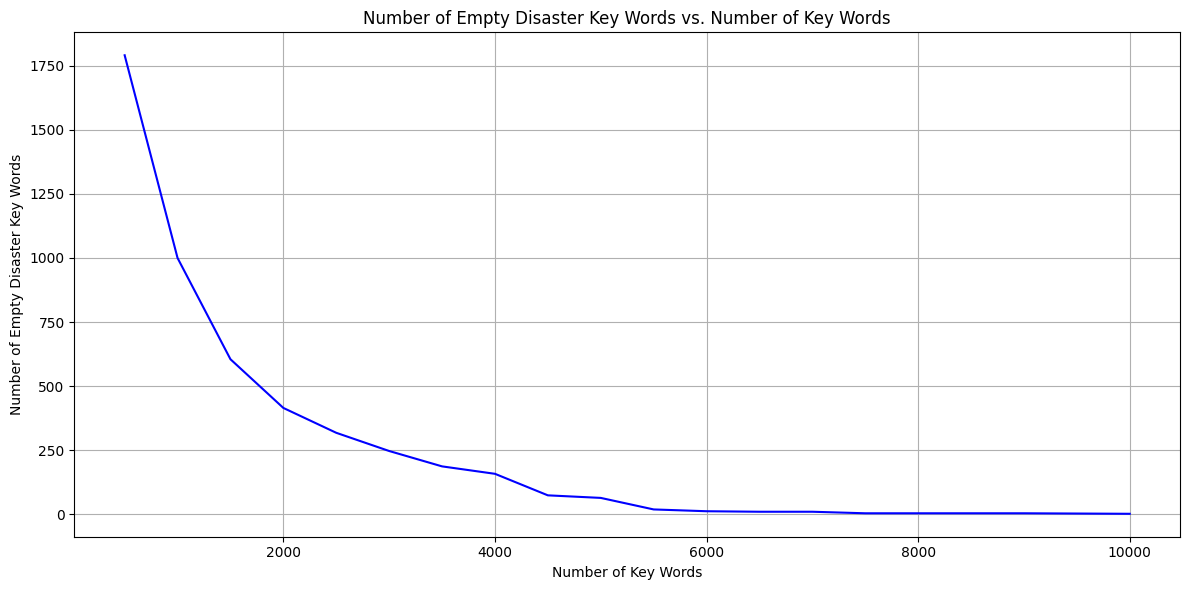

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(X_axis, y_axis, color='blue')
plt.title("Number of Empty Disaster Key Words vs. Number of Key Words")
plt.xlabel("Number of Key Words")
plt.ylabel("Number of Empty Disaster Key Words")
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
top_k_words = 6000
top_indices = importance.argsort()[-top_k_words:][::-1]
top_words = feature_names[top_indices]  

In [67]:
train_df_fnl["top_words"] = train_df_fnl["Remove_Hash_Link_At"].apply(keep_only_top_words)
val_df_fnl = val_df.copy()
test_df_fnl = test_df.copy()
val_df_fnl["top_words"] = val_df["Remove_Hash_Link_At"].apply(keep_only_top_words)
test_df_fnl["top_words"]= test_df["Remove_Hash_Link_At"].apply(keep_only_top_words)

In [68]:
train_df_fnl

,text,target,Remove_Hash_Link_At,Remove_Hash_Link_At_Combine,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,...,PCA_3304,PCA_3305,PCA_3306,PCA_3307,PCA_3308,PCA_3309,top_words,disaster_score,non_disaster_score,bias
0,Do you feel deluged by low self-image? Take th...,0,"[feel, delug, low, self-imag, take, quiz]",feel delug low self-imag take quiz,-0.103809,-0.004820,-0.069849,-0.055792,-0.012707,0.547366,...,-0.468706,0.047521,-0.411941,0.150299,-0.348786,-0.128443,"[feel, delug, low, take, quiz]",64,187,1
1,I'm drowning in spirits to wash you out,0,"[drown, spirit, wash]",drown spirit wash,-0.022870,-0.046965,-0.039346,-0.056824,0.015039,-0.026105,...,-0.470581,-0.142529,-0.776593,1.499534,-0.503235,0.083692,"[drown, spirit]",99,257,1
2,Lunch for the crew is made. Night night it's b...,0,"[lunch, crew, made, night, night, long, day, p...",lunch crew made night night long day peac love...,-0.118431,-0.081678,-0.069096,-0.011810,-0.048462,-0.031301,...,-0.863437,-0.902139,-0.041927,-0.027119,1.128388,1.424497,"[lunch, crew, made, night, night, long, day, p...",236,590,1
3,Baltimore City : I-95 NORTH AT MP 54.8 (FORT M...,1,"[baltimor, citi, 95, north, mp, 54.8, fort, mc...",baltimor citi 95 north mp 54.8 fort mchenri tu...,-0.101302,-0.088488,-0.108686,-0.139330,-0.067866,-0.022211,...,-0.655261,-0.039618,0.113906,-0.637715,0.313348,0.124221,"[citi, 95, north, fort, mchenri, bore, 95, nor...",349,646,1
4,I concur. The longer you spend with your child...,0,"[concur, longer, spend, child, harm, mmk]",concur longer spend child harm mmk,-0.100515,-0.066034,-0.051609,-0.019156,-0.034221,-0.026097,...,0.277074,-0.421111,0.040377,0.072370,-0.105157,-0.400602,"[concur, spend, child, harm, mmk]",363,691,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6084,If I could I would have been by at work but go...,0,"[could, would, work, got, injur, secur, concer...",could would work got injur secur concern must ...,-0.122435,-0.076033,-0.066928,-0.093147,0.077987,-0.098983,...,-0.331956,0.344637,-0.475023,0.285512,0.856661,-1.022422,"[could, would, work, got, injur, secur, concer...",906327,996280,1
6085,@UntamedDirewolf 'I... Wow. Alright.' Sansa sh...,0,"[wow, alright, sansa, shook, head, blink, rapi...",wow alright sansa shook head blink rapidli new...,-0.124342,-0.096810,-0.091506,-0.067413,-0.027625,-0.052506,...,-0.360378,-0.333349,-0.049440,-0.095271,-0.206000,0.604812,"[wow, alright, sansa, shook, head, blink, rapi...",906443,996602,1
6086,well it feels like im on fire.,0,"[well, feel, like, im, fire]",well feel like im fire,-0.105781,-0.044915,-0.061630,0.030155,-0.021312,-0.007631,...,-0.329315,-0.263997,-0.514500,0.417821,0.474201,0.152877,"[well, feel, like, im, fire]",906773,997043,1
6087,We destroyed the #Zimmerman fan club on Twitte...,0,"[destroy, zimmerman, fan, club, twitter, oblit...",destroy zimmerman fan club twitter obliter ren...,-0.119875,-0.094695,-0.017337,-0.098059,-0.046858,-0.042815,...,0.214931,0.369555,0.079218,-0.024805,0.057221,-0.210481,"[destroy, fan, club, twitter, obliter, reduc]",906840,997214,1


# 3. Build Word Dictionary
Use the training dataset to build the word dictionary. The word dictionary will use the ($word_i$, $label_i$) as key and the count of ($word_i$, $label_i$) occurrence as value

In [69]:
def build_word_dict(label_arr, token_word_arr):
    """Build frequencies.
    Input:
        token_word: a series of list of tokenized word
        label: a series of label that match the array of the list of tokenized word
    Output:
        freqs: a dictionary mapping each (word, label) pair to its frequency
    """
    word_dict = {}
    y_list = list(label_arr) # make array into list

    for label_idx in range(len(y_list)):

        for word in token_word_arr[label_idx]:
            word_dict[(word, y_list[label_idx])] = word_dict.get((word, y_list[label_idx]), 0) + 1
    return word_dict
        
word_dict = build_word_dict(train_df_fnl['target'], train_df_fnl["top_words"])    
  

    

In [70]:
print("number of words:", len(word_dict))
print("Output Example:", list(word_dict.items())[:10])

number of words: 8116
Output Example: [(('feel', 0), 64), (('delug', 0), 43), (('low', 0), 15), (('take', 0), 52), (('quiz', 0), 13), (('drown', 0), 62), (('spirit', 0), 7), (('lunch', 0), 4), (('crew', 0), 2), (('made', 0), 28)]


# Extract Information

$$X_m = [x_0, x_1, x_2]
    =[1, \sum_{i=1}^{m} Freq(_i, 1), \sum_{i=1}^{m}  Freq(w_i,0)]$$

$x_0$: bias

$x_1$: number of postive label for this word from the dictionary

$x_2$: number of negative label for this word from the dictionary

$m$: number of training tweets

In [74]:
def extract_info(word_dict,token_word_arr):
    """Extract Information from Each Tweets.
    Input:
        token_word_arr: a series of list of tokenized word
        word_dic: the dictionary with (w, label) as key and frequency as value
    Output:
        1. a list of total frequency for each word in the tweet that associate with disaster from the dictionary
        2. a list of total frequency for each word in the tweet that associate with not disaster from the dictionary
    """
    cnt_dis_word = 0
    cnt_non_dis_word = 0
    dis_lst = []
    non_dis_lst = []

    # iterate all rows
    for idx in range(len(token_word_arr)):
        # iterate all words at the token_word_arr[idx]
        for word in token_word_arr[idx]:
            cnt_dis_word += word_dict.get((word, 1), 0)
            cnt_non_dis_word += word_dict.get((word, 0), 0)

        dis_lst.append(cnt_dis_word)
        non_dis_lst.append(cnt_non_dis_word)
    return dis_lst, non_dis_lst
    

        

In [75]:
# Train Dataset
train_df_fnl['disaster_score'], train_df_fnl['non_disaster_score']= extract_info(word_dict,train_df_fnl["top_words"])
train_df_fnl['bias'] = [1]*len(train_df_fnl) # add bias term
X_train, y_train = train_df_fnl[["bias", "disaster_score", 'non_disaster_score']], train_df_fnl['target']

# Validation Dataset
val_df_fnl['disaster_score'], val_df_fnl['non_disaster_score']= extract_info(word_dict,val_df_fnl['top_words'])
val_df_fnl['bias'] = [1]*len(val_df_fnl) # add bias term
X_val, y_val = val_df_fnl[["bias", "disaster_score", 'non_disaster_score']], val_df_fnl['target']

# Test Dataset
test_df_fnl['disaster_score'], test_df_fnl['non_disaster_score']= extract_info(word_dict,test_df_fnl['Remove_Hash_Link_At'])
test_df_fnl['bias'] = [1]*len(test_df_fnl) # add bias term
X_test = test_df_fnl[["bias", "disaster_score", 'non_disaster_score']]

In [76]:
print(X_train.shape) #(m, 3)
print(X_val.shape) #(m, 3)


y_train = y_train.to_numpy().reshape(-1, 1)
y_val = y_val.to_numpy().reshape(-1, 1)
print(y_train.shape) #(m,1)
print(y_val.shape) # (m, 1)


(6089, 3)
(1524, 3)
(6089, 1)
(1524, 1)


# Overfitting
To avoid overfitting, I plan to implement the L2 Regression
$$\lambda*\frac{1}{2}\mathbf{\theta}^T\mathbf{\theta}$$

# Logistic Regression

* Sigmoid Function
$$ h(z) = \frac{1}{1+\exp^{-z}} $$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N = x^Tz$$

* Loss Function
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$
    * By Taking Derivative of Log of Likelihood: $$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x^{(i)}_j $$
* Loss Function with Ridge Regression
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)+\frac{\lambda}{2m}\mathbf{\theta}^T\mathbf{\theta}$$
    * By Taking Derivative of Log of Likelihood: $$\nabla_{\theta_j}J(\theta) = \frac{1}{m} (\sum_{i=1}^m(h^{(i)}-y^{(i)})x^{(i)}_j + \lambda \theta_j )$$
* Gradient Descent
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$

$\alpha$: learning rate



In [78]:
def sigmoid(z):
    """Calculate sigmoid.
    Input: a digit
    Output: the sigmoid of the digit
    """   
    z = np.clip(z, -500, 500)  # Prevent overflow
    return 1/(1+np.exp(-z))

In [79]:
def accuracy(pred_label, label_y):
    """Calculate accuracy.
    Input: predicted Y and actual Y value
    Output: a list contains 0 or 1 if the predicted Y is the same as label_y
    """  
    match_list = (pred_label == label_y).astype(int)
    accuracy_percentage = sum(match_list)/ len(match_list)
    return accuracy_percentage


In [80]:
def gradDescent(alpha, theta, train_X, train_Y, val_X, val_Y,iteration, lam):
    """Calculate sigmoid.
    Input: a digit
    Output: the sigmoid of the digit
    """   
    # initialize the train and validation loss list, also the theta
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    theta = np.zeros((3,1))

    # optimal_iter = 0

    # number of examples
    train_m = len(train_Y)  
    val_m = len(val_Y)
    
    
    for itera in range(iteration):

        # calculate the predicted y
        z = np.dot(train_X,theta) #(m,1)

        # put the predicted y into sigmoid
        sig = sigmoid(z) #(m,1)

        # Compute the gradient
        gradient = (1/train_m) * np.dot(train_X.T, (sig - train_Y)) #(3,1)
        gradient += (lam / train_m) * np.r_[[[0]], theta[1:]]  # exclude bias


        # update theta
        theta = theta - gradient * alpha #(3,1)


        # calculate the training loss
        train_z = np.dot(train_X,theta)        
        train_sig = sigmoid(train_z)
        train_sig = np.clip(train_sig, 1e-10, 1 - 1e-10)  # Prevent log(0)
        train_loss_val = (-1/train_m)* (train_Y.T @ np.log(train_sig)+(1-train_Y).T@ np.log(1-train_sig))[0,0]+(lam / (2 * train_m)) * np.sum(theta[1:] ** 2)
        train_loss.append(train_loss_val)

        # predict the training label
        pred_label_train = (train_sig >= 0.5).astype(int)
        # calculate the training accuray
        train_accuracy.append(accuracy_score(pred_label_train,train_Y))
        
        
        # calculate the validation loss
        val_z = np.dot(val_X,theta)
        val_sig = sigmoid(val_z)
        val_sig = np.clip(val_sig, 1e-10, 1 - 1e-10)  # Prevent log(0)
        val_loss_val = (-1/val_m)* (val_Y.T @ np.log(val_sig)+(1-val_Y).T@ np.log(1-val_sig))[0,0]
        val_loss.append(val_loss_val)   
        
        # predict the validation label
        pred_label_val = (val_sig  >= 0.5).astype(int)
        # calculate the training accuray
        val_accuracy.append(accuracy_score(pred_label_val,val_Y))
        


        
        # # update the theta optimal theta

        # curr_train_val_loss = np.log(train_loss_val) + np.log(val_loss_val)
        
        # if curr_train_val_loss < min_train_val_loss:
        #     theta_optimal = theta
        #     min_train_val_loss = curr_train_val_loss
        #     optimal_iter = itera

    
    return theta, train_loss, val_loss, train_accuracy, val_accuracy
    
    
    
    
    
    


In [81]:
y_axis[int(5500/500)]

12

In [89]:
theta = np.zeros((3,1))
alpha = 0.0001
iteration = 1000
lam = 0.0001
theta, train_loss, val_loss, train_accuracy, val_accuracy = gradDescent(alpha,theta,X_train,y_train, X_val, y_val,iteration, lam)

In [92]:
print(theta)
print(np.mean(train_accuracy))
print(np.mean(val_accuracy))

[[ 6.12110083e-04]
 [-1.18083485e+01]
 [-1.48843689e+01]]
0.5108411890293973
0.5108267716535433


In [ ]:
# import matplotlib.pyplot as plt
# iterations = range(1, iteration + 1)
# plt.figure(figsize=(20, 5))
# plt.plot(iterations, train_accuracy, label='Train Accuracy', color='blue')
# plt.plot(iterations, val_accuracy, label='Validation Accuracy', color='orange')
# plt.xlabel('Iteration')
# plt.ylabel('Accuracy')
# plt.title('Train vs Test Loss over Iterations')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

Reference: [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview)